<a href="https://colab.research.google.com/github/kharerahul002/Forecasting-Models/blob/master/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [0]:
quandl.ApiConfig.api_key = 'knewsUunFYUMpN7y7xKn'
data = quandl.get('BSE/BOM500325') #reliance
data

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
1991-01-02,115.0,115.00,105.00,107.50,0.00,0.0,0.0,0.000000e+00,NaN,NaN,10.00,-7.50
1991-01-03,107.5,107.50,95.00,97.50,0.00,0.0,0.0,0.000000e+00,NaN,NaN,12.50,-10.00
1991-01-07,105.0,107.50,97.50,105.00,0.00,0.0,0.0,0.000000e+00,NaN,NaN,10.00,0.00
1991-01-09,105.0,105.00,101.25,102.50,0.00,0.0,0.0,0.000000e+00,NaN,NaN,3.75,-2.50
1991-01-11,102.5,110.00,100.00,108.75,0.00,0.0,0.0,0.000000e+00,NaN,NaN,10.00,6.25
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,1354.9,1495.00,1348.00,1417.35,1426.94,2452068.0,84839.0,3.498957e+09,298577.0,12.18,147.00,62.45
2020-04-27,1440.0,1474.55,1422.95,1430.30,1449.14,1152767.0,42860.0,1.670522e+09,204866.0,17.77,51.60,-9.70
2020-04-28,1451.4,1454.75,1391.95,1428.10,1421.15,1301548.0,49487.0,1.849695e+09,159436.0,12.25,62.80,-23.30


In [0]:
dataset = data.drop(['WAP','No. of Shares','No. of Trades','Total Turnover','Deliverable Quantity',
                                    '% Deli. Qty to Traded Qty','Spread H-L','Spread C-O'], axis = 1)
dataset.head()

,Open,High,Low,Close
Date,,,,
1991-01-02,115.0,115.0,105.00,107.50
1991-01-03,107.5,107.5,95.00,97.50
1991-01-07,105.0,107.5,97.50,105.00
1991-01-09,105.0,105.0,101.25,102.50
1991-01-11,102.5,110.0,100.00,108.75


In [0]:
type(dataset)

pandas.core.frame.DataFrame

In [0]:
dataset = dataset.reset_index()

In [0]:
#dataset.rename(columns={'Date':'DATE'},inplace=True)

In [0]:
dataset['Mean'] = (dataset['Low'] + dataset['High'])/2
dataset.head(2)

,Date,Open,High,Low,Close,Mean
0,1991-01-02,115.0,115.0,105.0,107.5,110.00
1,1991-01-03,107.5,107.5,95.0,97.5,101.25


In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7091 entries, 0 to 7090
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7091 non-null   datetime64[ns]
 1   Open    7091 non-null   float64       
 2   High    7091 non-null   float64       
 3   Low     7091 non-null   float64       
 4   Close   7091 non-null   float64       
 5   Mean    7091 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 332.5 KB


In [0]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,Date,Open,High,Low,Close,Mean,Actual
0,1991-01-02,115.0,115.0,105.0,107.5,110.00,101.250
1,1991-01-03,107.5,107.5,95.0,97.5,101.25,102.500
2,1991-01-07,105.0,107.5,97.5,105.0,102.50,103.125


In [0]:
dataset_for_prediction=dataset_for_prediction.dropna()

In [0]:
#dataset_for_prediction['DATE'] =pd.to_datetime(dataset_for_prediction['DATE'])
#dataset_for_prediction.index= dataset_for_prediction['DATE']

Text(0.5, 1.0, 'Opening Stock Value')

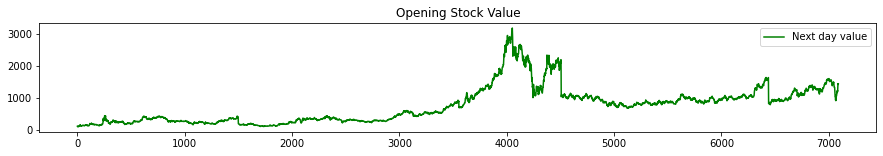

In [0]:
dataset_for_prediction['Mean'].plot(color='green', figsize=(15,2))
plt.legend(['Next day value', 'Mean'])
plt.title('Opening Stock Value')

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High', 'Open', 'Close', 'Mean']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [0]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output = pd.DataFrame(scaler_output)
y=scaler_output

In [0]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Mean'}, inplace=True)
X.head()

,Low,High,Open,Close,Mean
0,0.005334,0.006335,0.007160,0.0052,0.005843
1,0.002052,0.003959,0.004773,0.0020,0.003022
2,0.002872,0.003959,0.003978,0.0044,0.003425
3,0.004103,0.003167,0.003978,0.0036,0.003627
4,0.003693,0.004751,0.003182,0.0056,0.004231


In [0]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head()

,Stock Price next day
0,0.003022
1,0.003425
2,0.003627
3,0.004231
4,0.004030


In [0]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

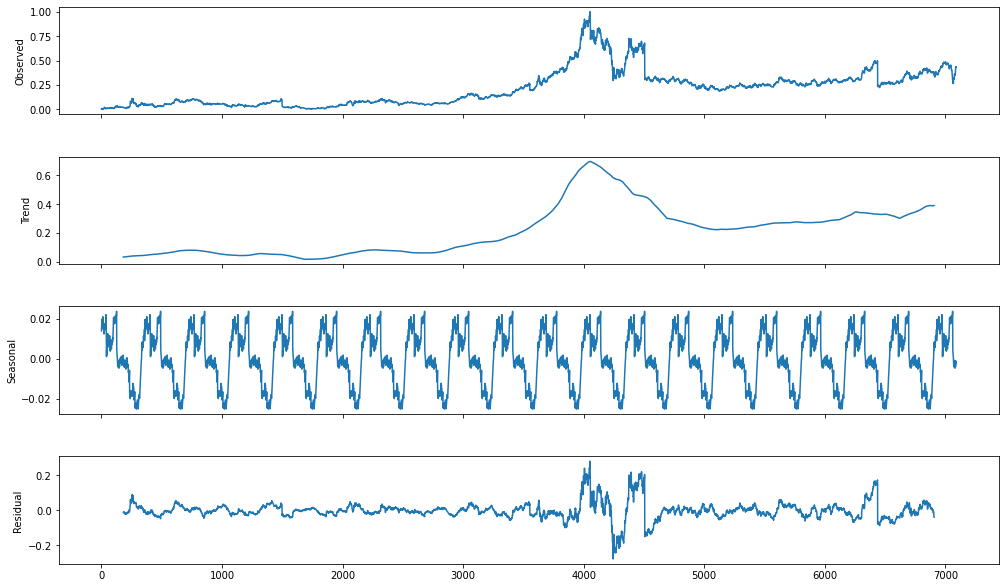

In [0]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Mean'],model='add',freq=365);
fig=seas_d.plot()
fig.set_size_inches(16, 9)
plt.show()

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [0]:
y_test=y['Stock Price next day'][:train_size].dropna()
test_adf(y_test, " Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for  Stock Price


In [0]:
test_adf(y_test.diff(), " Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary  Stock Price


In [0]:
#building a model

from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-33952.008, BIC=-33893.422, Time=17.621 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-33901.949, BIC=-33856.382, Time=10.867 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-33940.375, BIC=-33888.298, Time=9.618 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-33958.213, BIC=-33906.136, Time=21.301 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-33860.289, BIC=-33821.231, Time=4.791 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-33975.619, BIC=-33917.033, Time=6.999 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-33916.046, BIC=-33850.951, Time=20.344 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=-33969.386, BIC=-33904.290, Time=39.954 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=-33969.644, BIC=-33898.039, Time=32.138 seconds
Total fit time: 163.649 seconds


In [0]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4963
Model:               SARIMAX(0, 1, 2)   Log Likelihood               16996.810
Date:                Tue, 12 May 2020   AIC                         -33975.619
Time:                        12:25:12   BIC                         -33917.033
Sample:                             0   HQIC                        -33955.078
                               - 4963                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.048e-06      0.000      0.015      0.988      -0.000       0.000
Low        -7.426e+12      0.007  -1.08e+15      0.000   -7.43e+12   -7.43e+12
High       -7.696e+12      0.015  -5.22e+14      0.000    -7.7e+12    -7.7e+12
Open           0.0530      0.014      3.840      0.000       0.026       0.080
Close          0.6741      0.013     53.809      0.000       0.650       0.699
Mean        1.512e+13      0.008   1.85e+15      0.000    1.51e+13    1.51e+13
ma.L1         -0.0998      0.016     -6.132      0.000      -0.132      -0.068
ma.L2         -0.0016      0.008     -0.208      0.835      -0.017       0.014
sigma2      6.117e-05   1.07e-07    572.181      0.000     6.1e-05    6.14e-05
===================================================================================
Ljung-Box (Q):                       76.11   Jarque-Bera (JB):         150888851.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              21.67   Skew:                           -18.86
Prob(H) (two-sided):                  0.00   Kurtosis:                       856.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+17. Standard errors may be unstable.
"""

In [0]:
#train the model

from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y,
 exog=train_X,
 order=(0,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

In [0]:
results= model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
test_X

,Low,High,Open,Close,Mean
4963,0.226900,0.232175,0.233079,0.222460,0.229584
4964,0.221976,0.220772,0.216627,0.217437,0.221363
4965,0.216560,0.214564,0.215752,0.213741,0.215544
4966,0.223913,0.223433,0.216770,0.226108,0.223669
4967,0.229739,0.227741,0.229594,0.225836,0.228722
...,...,...,...,...,...
7085,0.415395,0.408872,0.406428,0.409673,0.412075
7086,0.413343,0.443445,0.401718,0.424345,0.428662
7087,0.437945,0.436967,0.428799,0.428489,0.437448
7088,0.427770,0.430696,0.432426,0.427785,0.429259


In [0]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 4963 to 7089
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Low     2127 non-null   float64
 1   High    2127 non-null   float64
 2   Open    2127 non-null   float64
 3   Close   2127 non-null   float64
 4   Mean    2127 non-null   float64
dtypes: float64(5)
memory usage: 99.7 KB


In [0]:
predictions= results.predict(start = train_size, end=train_size+test_size+(steps)-1,exog=test_X)

In [0]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

In [0]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [0]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

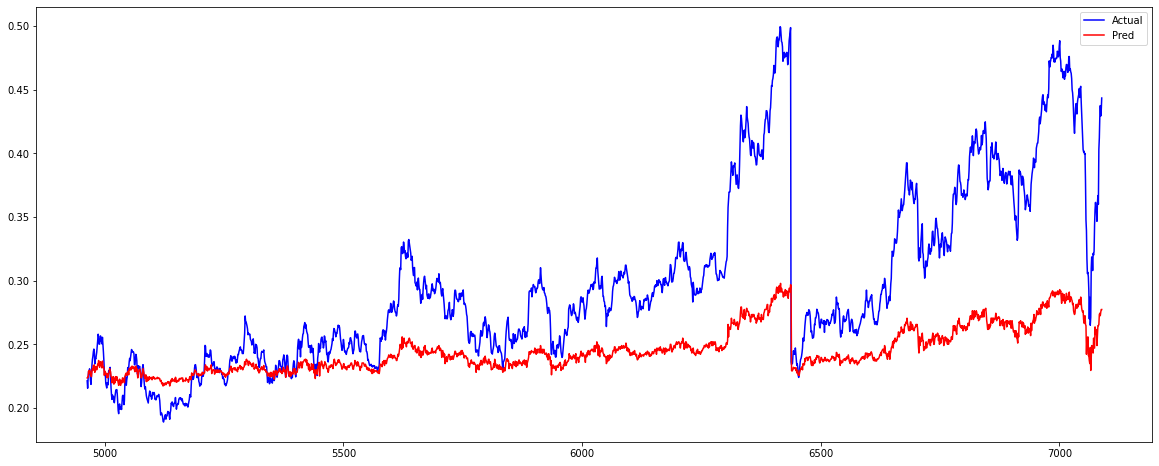

In [0]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [0]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

0.07376564022424532